In [1]:
%pip install tf-nightly pyreadstat pandas matplotlib numpy

import os
import logging
import warnings

# ==================== Environment & Warning Suppression ====================
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs (0=all, 3=errors only)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN (may improve CPU stability)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU-only (comment if GPU is available)

# Suppress warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ==================== Imports ====================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyreadstat  # Replacement for xport
import tensorflow as tf  # Import TensorFlow
print(tf.__version__)  # Should print the nightly build version

# Use tf.keras for compatibility with tf-nightly
keras = tf.keras
Sequential = keras.Sequential
Dense = keras.layers.Dense

print("All imports successful!")

# ==================== TensorFlow Optimization ====================
if tf.config.list_physical_devices('GPU'):
    print("GPU detected - TensorFlow will use GPU acceleration")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("Running on CPU - For better performance, install CUDA-compatible GPU drivers")

# ==================== Sample Usage ====================
def load_sas_file(filepath):
    """Load SAS files using pyreadstat (replaces xport)"""
    try:
        df, meta = pyreadstat.read_sas7bdat(filepath)
        return df
    except Exception as e:
        print(f"Error loading SAS file: {e}")
        return None

# Example usage
data = load_sas_file("example.sas7bdat")
if data is not None:
    print(data.head())

Note: you may need to restart the kernel to use updated packages.
2.20.0-dev20250623
All imports successful!
Running on CPU - For better performance, install CUDA-compatible GPU drivers
Error loading SAS file: File example.sas7bdat does not exist!


1.Data Scientist
For the data scientist, the focus is on evaluating and understanding the model before deployment. They need to ensure the model’s transparency, fairness, and compliance with industry standards.
Interpretable rule-based models help the data scientist verify the model’s decision-making process, making sure it aligns with ethical and regulatory guidelines.

In [ ]:
# ====== Enhanced Data Loading & Target Encoding ======
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load dataset
heloc_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/TpQl93NfuzpDVAPaFzs8qg/heloc-dataset-v1.csv'
dataset = pd.read_csv(heloc_url)

# Encode target variable
label_encoder = LabelEncoder()
dataset['RiskPerformance'] = label_encoder.fit_transform(dataset['RiskPerformance'])
# Good=1, Bad=0 (maintaining original convention)

print("Target variable distribution:")
print(dataset['RiskPerformance'].value_counts())
dataset.head()

Target variable distribution:
RiskPerformance
0    5459
1    5000
Name: count, dtype: int64


,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,0,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,0,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,0,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,0,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,0,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [ ]:
# ====== Feature Preprocessing for Interpretability ======
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Separate features and target
X = dataset.drop('RiskPerformance', axis=1)
y = dataset['RiskPerformance']

# Robust scaling (preserves outliers for rule-based models)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (8367, 23)
Test set shape: (2092, 23)


In [ ]:
# ====== Proper Feature Selection & Model Training ======
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from interpret import show
import numpy as np

# 1. Feature Selection First
print("Performing feature selection...")
selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
    threshold='median'
).fit(X_train, y_train)

selected_features = X.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features:", list(selected_features))

# 2. Boolean Rule Column Generation (EBM) on selected features
print("\nTraining Boolean Rules Column Generation (EBM)...")
ebm = ExplainableBoostingClassifier(
    feature_names=selected_features,
    interactions=0,
    max_bins=256,
    random_state=42
)
ebm.fit(X_train[selected_features], y_train)

# 3. Logistic Regression on selected features
print("\nTraining Logistic Regression...")
lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lr.fit(X_train[selected_features], y_train)

# Model explanations
print("\n=== EBM Global Explanation ===")
show(ebm.explain_global())

print("\n=== Logistic Regression Coefficients ===")
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr.coef_[0],
    'Odds_Ratio': np.exp(lr.coef_[0]),
    'Direction': np.where(lr.coef_[0] > 0, "Increases Risk", "Decreases Risk")
}).sort_values('Coefficient', key=abs, ascending=False)

display(coef_df.head(10))  # <-- Use display() instead of show()

# Generate human-readable rules
print("\n=== Business Rules ===")
for feature, coef in zip(selected_features, lr.coef_[0]):
    if abs(coef) > 0.1:  # Only show meaningful predictors
        direction = "higher" if coef > 0 else "lower"
        print(f"• {feature}: {direction} values → {'higher risk' if coef > 0 else 'lower risk'}")

Performing feature selection...
Selected 12 features: ['ExternalRiskEstimate', 'AverageMInFile', 'NumSatisfactoryTrades', 'PercentTradesNeverDelq', 'MaxDelq2PublicRecLast12M', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NumRevolvingTradesWBalance']

Training Boolean Rules Column Generation (EBM)...

Training Logistic Regression...

=== EBM Global Explanation ===


<!-- http://127.0.0.1:7001/2321052850160/ -->


=== Logistic Regression Coefficients ===


,Feature,Coefficient,Odds_Ratio,Direction
8,NumInqLast6M,-0.819593,0.440611,Decreases Risk
10,NetFractionRevolvingBurden,-0.694846,0.499152,Decreases Risk
2,NumSatisfactoryTrades,0.578677,1.783676,Increases Risk
9,NumInqLast6Mexcl7days,0.490034,1.632372,Increases Risk
0,ExternalRiskEstimate,0.463090,1.588976,Increases Risk
6,PercentInstallTrades,-0.410296,0.663454,Decreases Risk
11,NumRevolvingTradesWBalance,-0.294432,0.744955,Decreases Risk
5,NumTradesOpeninLast12M,-0.266099,0.766363,Decreases Risk
1,AverageMInFile,0.226369,1.254038,Increases Risk
7,MSinceMostRecentInqexcl7days,0.169077,1.184211,Increases Risk



=== Business Rules ===
• ExternalRiskEstimate: higher values → higher risk
• AverageMInFile: higher values → higher risk
• NumSatisfactoryTrades: higher values → higher risk
• PercentTradesNeverDelq: higher values → higher risk
• NumTradesOpeninLast12M: lower values → lower risk
• PercentInstallTrades: lower values → lower risk
• MSinceMostRecentInqexcl7days: higher values → higher risk
• NumInqLast6M: lower values → lower risk
• NumInqLast6Mexcl7days: higher values → higher risk
• NetFractionRevolvingBurden: lower values → lower risk
• NumRevolvingTradesWBalance: lower values → lower risk


In [ ]:
# ====== Rule Extraction & Evaluation ======
from interpret.perf import ROC

# Evaluate models
ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test[selected_features], y_test)
lr_perf = ROC(lr.predict_proba).explain_perf(X_test[selected_features], y_test)

print("EBM Performance:")
show(ebm_perf)

print("\nLR Performance:")
show(lr_perf)

# Extract human-readable rules
print("\nTop EBM Rules:")
ebm_global = ebm.explain_global()
importances = ebm_global.data()['scores']
features = ebm_global.data()['names']
top_idx = np.argsort(importances)[::-1][:5]
for i in top_idx:
    print(f"{features[i]}: {importances[i]:.3f}")

print("\nLR Decision Threshold:")
print(f"Intercept: {lr.intercept_[0]:.3f}")
print("Most influential features:")
for coef, feat in sorted(zip(lr.coef_[0], selected_features), reverse=True)[:5]:
    print(f"{feat}: {coef:.3f}")

EBM Performance:


<!-- http://127.0.0.1:7001/2321085678320/ -->


LR Performance:


<!-- http://127.0.0.1:7001/2321085042512/ -->


Top EBM Rules:
ExternalRiskEstimate: 0.441
MSinceMostRecentInqexcl7days: 0.386
NumSatisfactoryTrades: 0.261
NetFractionRevolvingBurden: 0.248
AverageMInFile: 0.222

LR Decision Threshold:
Intercept: 0.253
Most influential features:
NumSatisfactoryTrades: 0.579
NumInqLast6Mexcl7days: 0.490
ExternalRiskEstimate: 0.463
AverageMInFile: 0.226
MSinceMostRecentInqexcl7days: 0.169


Loan Officer
The loan officer uses the model’s predictions to make final credit decisions. Their priority is to understand each prediction in a way that’s relatable and actionable.
Example-based explanations allow the loan officer to see comparable cases, making the model’s output more interpretable and practical for real-world decision-making.

In [ ]:
# ====== Setup & Data Preparation ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Load HELOC dataset
heloc_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/TpQl93NfuzpDVAPaFzs8qg/heloc-dataset-v1.csv'
data = pd.read_csv(heloc_url)

# Encode target
data['RiskPerformance'] = data['RiskPerformance'].map({'Good':1, 'Bad':0})

# Split features and target
X = data.drop('RiskPerformance', axis=1)
y = data['RiskPerformance']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# ====== Similar Applicant Finder ======
class ApplicantExplainer:
    def __init__(self, X_train, y_train, feature_names, n_neighbors=5):
        self.nn = NearestNeighbors(n_neighbors=n_neighbors)
        self.nn.fit(X_train)
        self.X_train = X_train
        self.y_train = y_train
        self.feature_names = feature_names
        
    def explain(self, applicant_data, applicant_id=None):
        distances, indices = self.nn.kneighbors(applicant_data.reshape(1, -1))
        
        explanation = pd.DataFrame({
            'Feature': self.feature_names,
            'Applicant_Value': applicant_data,
            'Avg_Similar_Value': self.X_train[indices[0]].mean(axis=0)
        })
        
        similar_profiles = pd.DataFrame(
            self.X_train[indices[0]], 
            columns=self.feature_names
        )
        similar_profiles['RiskPerformance'] = self.y_train.iloc[indices[0]].values
        similar_profiles['Distance'] = distances[0]
        
        return explanation, similar_profiles

# Initialize explainer
explainer = ApplicantExplainer(X_train, y_train, X.columns)

In [ ]:
# ====== Neural Network Training ======
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', keras.metrics.AUC(name='auc')])

history = model.fit(X_train, y_train,
                   epochs=20,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.6816 - auc: 0.7376 - loss: 0.6046 - val_accuracy: 0.7162 - val_auc: 0.7896 - val_loss: 0.5567
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7187 - auc: 0.7834 - loss: 0.5618 - val_accuracy: 0.7180 - val_auc: 0.7957 - val_loss: 0.5500
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7199 - auc: 0.7905 - loss: 0.5539 - val_accuracy: 0.7192 - val_auc: 0.7979 - val_loss: 0.5480
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7321 - auc: 0.7959 - loss: 0.5481 - val_accuracy: 0.7282 - val_auc: 0.7984 - val_loss: 0.5476
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7257 - auc: 0.7951 - loss: 0.5488 - val_accuracy: 0.7258 - val_auc: 0.7972 - val_loss: 0.5504
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7245 - auc: 0.7953 - loss: 0.5490 - val_accuracy: 0.7157 - val_auc: 0.7998 - val_loss: 0.5461
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Explanation for Applicant 0 (Predicted: Good)

Feature Comparison:


,Feature,Applicant_Value,Avg_Similar_Value
0,ExternalRiskEstimate,0.074536,0.330210
1,MSinceOldestTradeOpen,-0.330104,-0.014637
2,MSinceMostRecentTradeOpen,-0.341585,-0.251367
3,AverageMInFile,-0.202246,0.050455
4,NumSatisfactoryTrades,1.658908,1.120600
5,NumTrades60Ever2DerogPubRec,-0.017002,-0.017002
6,NumTrades90Ever2DerogPubRec,0.060341,0.060341
7,PercentTradesNeverDelq,0.513051,0.513051
8,MSinceMostRecentDelq,-0.671328,-0.671328
9,MaxDelq2PublicRecLast12M,0.551559,0.551559



Most Similar Historical Profiles:


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,RiskPerformance,Distance
0,0.453313,-0.020108,-0.341585,-0.099103,1.505105,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,-0.273077,-0.258498,-0.619784,0.162498,0.637892,0.498400,-0.005381,-0.435910,1,1.538685
1,0.358619,-0.074813,-0.116040,0.597116,0.966797,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,-0.273077,-0.258498,-0.486711,0.661315,1.317707,0.252143,0.292417,0.177582,1,1.751954
2,0.216577,-0.165988,-0.491948,-0.408533,0.736094,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,-0.273077,-0.258498,0.078849,1.207639,0.184681,0.252143,0.292417,-1.049401,1,1.797075
3,0.169230,-0.047460,-0.116040,-0.124888,1.120600,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.041473,0.059614,0.078849,1.041366,0.864497,0.498400,0.292417,-0.435910,0,1.815838
4,0.453313,0.235184,-0.191221,0.287685,1.274402,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.041473,0.059614,-0.054224,0.328770,-0.041924,0.252143,0.292417,-1.121577,1,1.852713


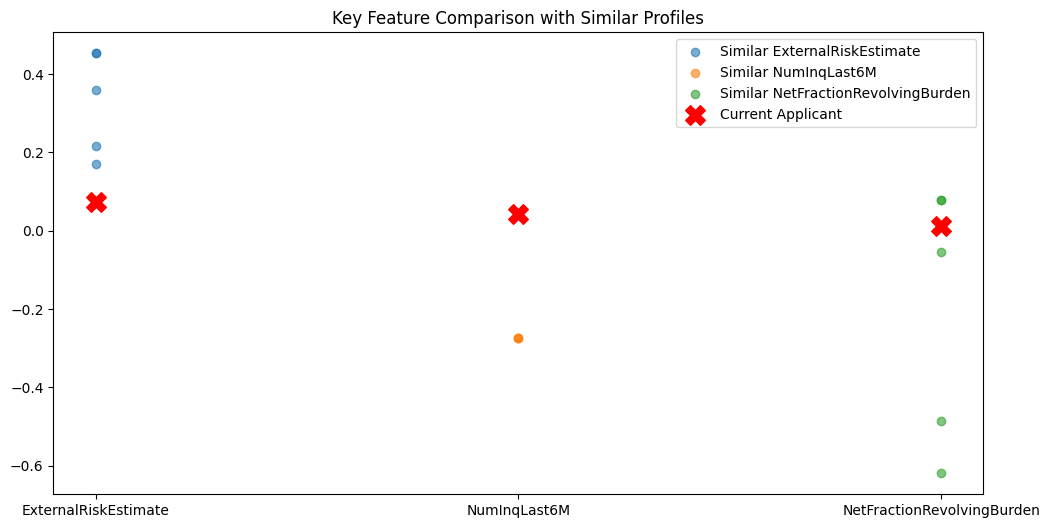

In [ ]:
# ====== Example Explanation ======
def generate_explanation(applicant_id):
    # Get test case
    applicant_data = X_test[applicant_id]
    
    # Get prediction
    pred = model.predict(applicant_data.reshape(1, -1))[0][0]
    pred_label = 'Good' if pred > 0.5 else 'Bad'
    
    # Get similar profiles
    feat_explanation, similar_profiles = explainer.explain(applicant_data)
    
    # Display results
    print(f"\nExplanation for Applicant {applicant_id} (Predicted: {pred_label})")
    print("\nFeature Comparison:")
    display(feat_explanation.head(10))
    
    print("\nMost Similar Historical Profiles:")
    display(similar_profiles)
    
    # Plot key features
    plt.figure(figsize=(12,6))
    for feat in ['ExternalRiskEstimate', 'NumInqLast6M', 'NetFractionRevolvingBurden']:
        plt.scatter(
            [feat]*len(similar_profiles),
            similar_profiles[feat],
            label=f'Similar {feat}',
            alpha=0.6
        )
    plt.scatter(
        ['ExternalRiskEstimate', 'NumInqLast6M', 'NetFractionRevolvingBurden'],
        [applicant_data[X.columns.get_loc(f)] for f in ['ExternalRiskEstimate', 'NumInqLast6M', 'NetFractionRevolvingBurden']],
        color='red', marker='X', s=200, label='Current Applicant'
    )
    plt.legend()
    plt.title('Key Feature Comparison with Similar Profiles')
    plt.show()

# Generate explanation for first test case
generate_explanation(0)

3.Customer
For the customer, clarity on why their application was approved or denied is essential. As non-technical users, they require straightforward explanations.
Contrastive explanations offer insights into the features that contributed to their result and what could have led to a different outcome, providing them with a clear understanding of the decision.

In [ ]:
# ====== Contrastive Explanation Setup ======
from sklearn.neighbors import NearestNeighbors
import numpy as np

class ContrastiveExplainer:
    def __init__(self, model, X_train, y_train, feature_names):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.feature_names = feature_names
        self.nn = NearestNeighbors(n_neighbors=50)
        self.nn.fit(X_train)
        
    def _find_counterfactuals(self, x, target_class, n=5):
        """Find nearest instances of the target class"""
        distances, indices = self.nn.kneighbors(x.reshape(1, -1))
        candidates = self.X_train[indices[0]]
        candidate_labels = self.y_train.iloc[indices[0]]
        valid_candidates = candidates[candidate_labels == target_class]
        return valid_candidates[:n]
    
    def get_pertinent_negatives(self, x, original_pred):
        """Find minimal changes that would flip the decision"""
        target_class = 1 - original_pred
        counterfactuals = self._find_counterfactuals(x, target_class)
        
        if len(counterfactuals) == 0:
            return None
            
        # Find minimal changes
        diffs = counterfactuals - x
        changes = []
        for i in range(len(counterfactuals)):
            # Get features with largest positive changes for bad->good
            if original_pred == 0:
                change_indices = np.argsort(-diffs[i])  # Features needing most improvement
            else:
                change_indices = np.argsort(diffs[i])  # Features that could worsen
            
            for idx in change_indices:
                if abs(diffs[i][idx]) > 0.5:  # Significant changes only
                    changes.append({
                        'feature': self.feature_names[idx],
                        'current_value': x[idx],
                        'required_value': counterfactuals[i][idx],
                        'change_needed': counterfactuals[i][idx] - x[idx]
                    })
                    break  # Only show most important change per counterfactual
        return changes
    
    def get_pertinent_positives(self, x, original_pred):
        """Find features that most strongly support the current decision"""
        same_class = self.X_train[self.y_train == original_pred]
        if len(same_class) == 0:
            return None
            
        # Find median of same-class instances
        median_profile = np.median(same_class, axis=0)
        
        # Find features where applicant is better than median (for good) or worse (for bad)
        pp = []
        for i in range(len(x)):
            if (original_pred == 1 and x[i] > median_profile[i]) or \
               (original_pred == 0 and x[i] < median_profile[i]):
                pp.append({
                    'feature': self.feature_names[i],
                    'your_value': x[i],
                    'median_value': median_profile[i],
                    'importance': abs(x[i] - median_profile[i])
                })
        
        # Sort by importance
        return sorted(pp, key=lambda x: -x['importance'])[:5]  # Top 5 most important

# Initialize explainer
contrastive_explainer = ContrastiveExplainer(model, X_train, y_train, X.columns)


In [ ]:
# ====== Generate Explanations for an Applicant ======
def generate_contrastive_explanation(applicant_id):
    applicant_data = X_test[applicant_id]
    original_pred = int(model.predict(applicant_data.reshape(1, -1))[0][0] > 0.5)
    
    print(f"\n=== Contrastive Explanation for Applicant {applicant_id} ===")
    print(f"Original Prediction: {'Good' if original_pred else 'Bad'}")
    
    # Pertinent Positives
    pps = contrastive_explainer.get_pertinent_positives(applicant_data, original_pred)
    print("\nPertinent Positives (Why you got this decision):")
    for pp in pps[:3]:  # Show top 3
        direction = "better" if original_pred == 1 else "worse"
        print(f"- Your {pp['feature']} ({pp['your_value']:.1f}) is {direction} than "
              f"typical {'Good' if original_pred else 'Bad'} applicants ({pp['median_value']:.1f})")
    
    # Pertinent Negatives
    pns = contrastive_explainer.get_pertinent_negatives(applicant_data, original_pred)
    print("\nPertinent Negatives (What could change the decision):")
    if not pns:
        print("No realistic changes would flip this decision")
    else:
        for pn in pns[:3]:  # Show top 3
            action = "increase" if pn['change_needed'] > 0 else "decrease"
            print(f"- If you {action} your {pn['feature']} from {pn['current_value']:.1f} "
                  f"to {pn['required_value']:.1f}, you might get {'Good' if not original_pred else 'Bad'}")

# Generate explanation
generate_contrastive_explanation(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step

=== Contrastive Explanation for Applicant 0 ===
Original Prediction: Good

Pertinent Positives (Why you got this decision):
- Your NumSatisfactoryTrades (1.7) is better than typical Good applicants (0.1)
- Your NumTotalTrades (1.4) is better than typical Good applicants (0.1)
- Your NumTradesOpeninLast12M (0.9) is better than typical Good applicants (-0.1)

Pertinent Negatives (What could change the decision):
- If you decrease your NumSatisfactoryTrades from 1.7 to 1.1, you might get Bad
- If you decrease your NumSatisfactoryTrades from 1.7 to 0.7, you might get Bad
- If you decrease your NumSatisfactoryTrades from 1.7 to 1.0, you might get Bad


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


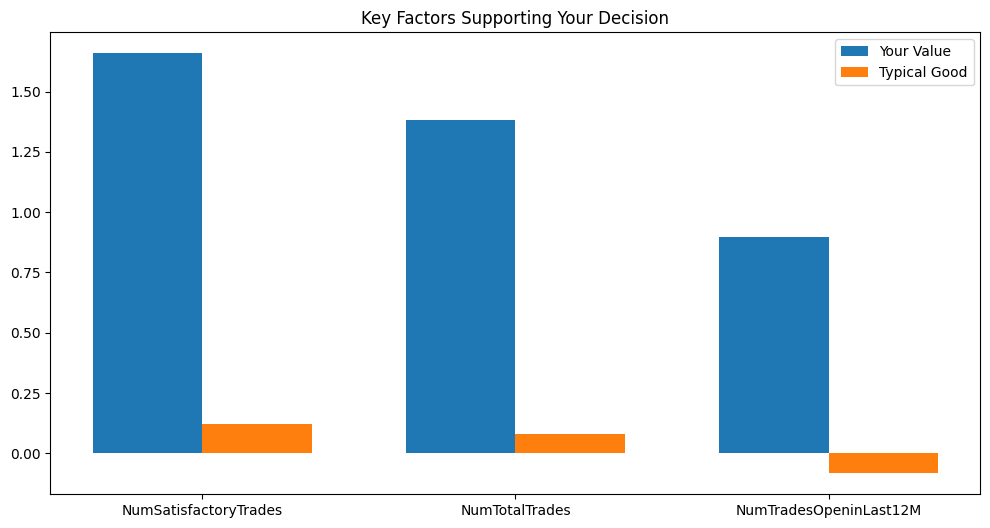

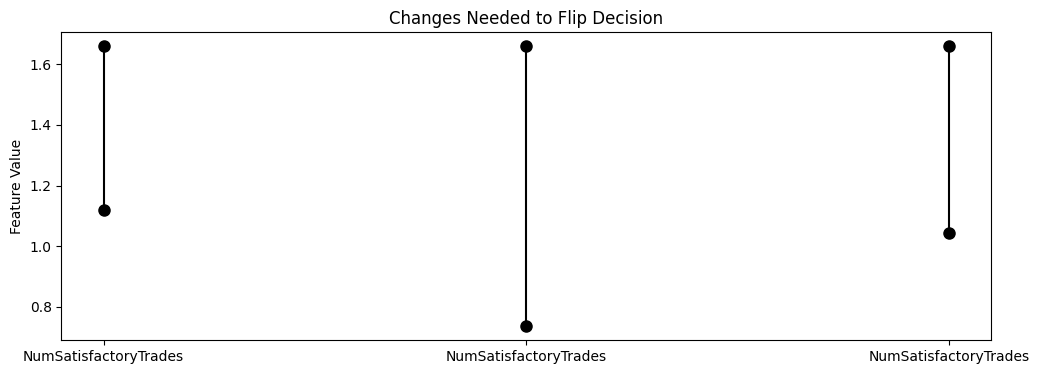

In [ ]:
# ====== Visual Explanation ======
def visualize_contrastive(applicant_id):
    applicant_data = X_test[applicant_id]
    original_pred = int(model.predict(applicant_data.reshape(1, -1))[0][0] > 0.5)
    
    pps = contrastive_explainer.get_pertinent_positives(applicant_data, original_pred)
    pns = contrastive_explainer.get_pertinent_negatives(applicant_data, original_pred)
    
    plt.figure(figsize=(12, 6))
    
    # Plot pertinent positives
    if pps:
        pp_features = [pp['feature'] for pp in pps[:3]]
        pp_yours = [pp['your_value'] for pp in pps[:3]]
        pp_median = [pp['median_value'] for pp in pps[:3]]
        
        x = range(len(pp_features))
        width = 0.35
        plt.bar([i - width/2 for i in x], pp_yours, width, label='Your Value')
        plt.bar([i + width/2 for i in x], pp_median, width, label=f'Typical {"Good" if original_pred else "Bad"}')
        plt.xticks(x, pp_features)
        plt.title('Key Factors Supporting Your Decision')
        plt.legend()
        plt.show()
    
    # Plot pertinent negatives
    if pns:
        pn_features = [pn['feature'] for pn in pns[:3]]
        current_values = [pn['current_value'] for pn in pns[:3]]
        required_values = [pn['required_value'] for pn in pns[:3]]
        
        plt.figure(figsize=(12, 4))
        for i, (feat, curr, req) in enumerate(zip(pn_features, current_values, required_values)):
            plt.plot([i, i], [curr, req], 'k-', marker='o', markersize=8)
        plt.xticks(range(len(pn_features)), pn_features)
        plt.title('Changes Needed to Flip Decision')
        plt.ylabel('Feature Value')
        plt.show()

visualize_contrastive(0)